# conditional Auxillary Classifier GAN
Train an auxillary classifier GAN on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in
vaegan.gan.py, our class for loading the MNIST dataset defined in
vaegan.data, and our custom Keras callback in vaegan.conditional.callbacks.

A directory called 'output' will be created to save figures and the trained
model. 


In [1]:
# nEpochs=20  # orig, longer training
nEpochs=3  # quick testing during development


## 1. Import 3rd party libraries 

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import our own classes 
current_dir =  '/project/nanocourse/SWE_OOP/train09/Module_2_Materials/04_ExerciseCodeAndInstructions/vaegan'
os.chdir(current_dir)
print("Current working directory:", os.getcwd())
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional
from vaegan.gan import ConditionalGAN

2025-05-28 16:09:04.024316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 16:09:04.047885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748466544.068425    3813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748466544.074635    3813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748466544.090177    3813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Current working directory: /project/nanocourse/SWE_OOP/train09/Module_2_Materials/04_ExerciseCodeAndInstructions/vaegan


## 3. Show some our data

2025-05-28 16:09:08.269379: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


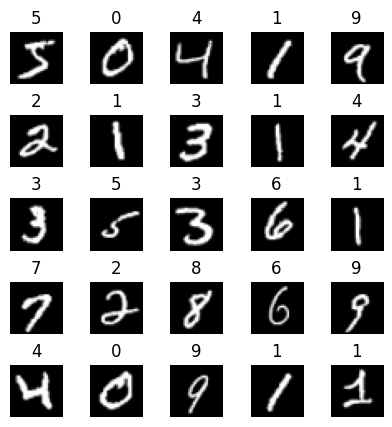

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist_cgan'
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = ConditionalGAN(n_classes=n_classes)

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.gan
Loaded version: vaegan.gan


In [5]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== GENERATOR SUBMODEL ====")
gen_in = tf.keras.layers.Input(shape=(model.n_latent_dims+n_classes,))
gen_out  = model.generator.call(gen_in) 
gen = tf.keras.Model(gen_in, gen_out) 
gen.summary()
print("=== DISCRIMINATOR SUBMODEL ====")
disc_in = tf.keras.layers.Input(shape=model.image_shape) 
disc_out  = model.discriminator.call(disc_in) 
disc = tf.keras.Model(disc_in, disc_out) 
disc.summary()



=== OVERALL MODEL ====


Model: "cgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator (Generator)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Discriminator)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator                   │ ?                      │   0 (unbuilt) │
│ (MultiTaskDiscriminator)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== GENERATOR SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │     1,138,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense (LeakyReLU)          │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2DTranspose)         │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (LeakyReLU)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2DTranspose)         │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (LeakyReLU)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,385 (6.35 MB)

 Trainable params: 1,664,385 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

=== DISCRIMINATOR SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        544 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        128 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (ReLU)        │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     32,832 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_real (Dense)  │ (None, 1)         │     16,385 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_class (Dense) │ (None, 10)        │    163,850 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_real        │ (None, 1)         │          0 │ dense_real[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_class       │ (None, 10)        │          0 │ dense_class[0][0] │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,995 (835.92 KB)

 Trainable params: 213,803 (835.17 KB)

 Non-trainable params: 192 (768.00 B)

## 6. Compile the model 

In [6]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                 example_labels=labels_onehot[:10],
                                                 n_generated_images=10,
                                                 n_latent_dims=model.n_latent_dims)

## 7. Train (fit) the model on the data 

In [7]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit(x=[data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/3
images_train: (None, 32, 32, 1)
labels_onehot: (None, 10)


/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'discriminator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


pred_class_fake: (None, 10)
class_fake     : (None, 10)


/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


images_train: (None, 32, 32, 1)
labels_onehot: (None, 10)
pred_class_fake: (None, 10)
class_fake     : (None, 10)
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - class_acc: 0.4739 - loss_disc: 2.2934 - loss_gen: 3.3165
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - class_acc: 0.8668 - loss_disc: 2.5775 - loss_gen: 1.0007
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - class_acc: 0.9023 - loss_disc: 2.5045 - loss_gen: 0.6177


## 8. Training saves results to disk, now also plot training curves

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


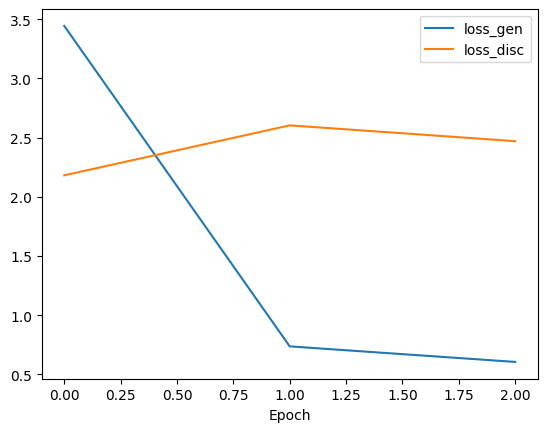

In [10]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['loss_gen', 'loss_disc']:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)
    
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, 'cgan.keras'))
